## Real Estate Price Prediction
### Geekbrains AI/BigData Python for Data Science course competition

### 1. Подготовка

In [1]:
# Импортируем основные библиотеки
import datetime
import gc

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# Пути к файлам
DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

#### Вспомогательная функция

In [3]:
# Функция уменьшения потребляемой памяти
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#### Загрузка данных

In [4]:
df = pd.read_csv(DATASET_PATH)
df = reduce_mem_usage(df)
X = df.drop('Price', axis = 1).copy()
y = df[['Price']].copy()
X_final = pd.read_csv(TEST_DATASET_PATH)
X_final = reduce_mem_usage(X_final)

# Датафрейм с предсказаниями
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

df.set_index('Id', inplace=True)
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.31 MB
Decreased by 56.6%


### 2. Исследование данных

#### Рассмотрим данные всего датафрейма

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839523,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315712,21.058718,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199596,86.241112,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.561113,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.776192,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119026,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int16  
 1   Rooms          10000 non-null  float32
 2   Square         10000 non-null  float32
 3   LifeSquare     7887 non-null   float32
 4   KitchenSquare  10000 non-null  float32
 5   Floor          10000 non-null  int8   
 6   HouseFloor     10000 non-null  float32
 7   HouseYear      10000 non-null  int32  
 8   Ecology_1      10000 non-null  float32
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int8   
 12  Social_2       10000 non-null  int16  
 13  Social_3       10000 non-null  int16  
 14  Healthcare_1   5202 non-null   float32
 15  Helthcare_2    10000 non-null  int8   
 16  Shops_1        10000 non-null  int8   
 17  Shops_2        10000 non-null  object 
 18  Pri

Можем отметить следующие особенности: 
1. Признаки LifeSquare и Healthcare_1 имеют пропуски. Причем для Healthcare_1 число пропусков составляет почти половину от всей выборки.
2. Для признаков KitchenSquare и HouseFloor минимальным значением является 0, что требует обработки. Ноль для признака комнаты может свидетельствовать о квартире-студии, поэтому обработка данных значений может не потребоваться (требуется дополнительное исследование).
3. Для признаков KitchenSquare, HouseFloor, HouseYear максимальные значения неадекватны, это требует обработки. Для признаков Rooms, Square, LifeSquare, Floor максимальные значения выглядят подозрительно и требуют дополнительного исследования.
4. Признаки Ecology_2, Ecology_3, Shops_2 - категориальные. Необходимо будет перекодировать их.

#### Исследуем дополнительно каждый из основных признаков (Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear)

#### Rooms

In [7]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

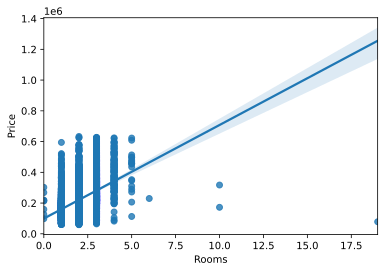

In [8]:
grid = sns.regplot(x='Rooms', y='Price', data=df)

Значения 0 и >5 необходимо обработать.

#### Square, LifeSquare, KitchenSquare

Введем в датафрейм дополнительные параметры для проведения анализа

In [9]:
# цена за метр
df['PricePerMeter'] = df['Price'] / df['Square']
# площадь на комнату
df['SquarePerRoom'] = df['Square'] / df['Rooms']
df.loc[df['SquarePerRoom'] == np.inf, 'SquarePerRoom'] = df['Square']

Определим в качестве "подозрительных" данных следующие и исследуем их вручную:
1. 15 (при этом PricePerMeter или SquarePerRoom входит в 99,9% процентиль) > Square > 150 (при этом PricePerMeter или SquarePerRoom входит в 0,1% процентиль).
2. 10 > LifeSquare > 0.9 * Square
3. 5 > KitchenSquare > 0.4 * Square
4. LifeSquare + KitchenSquare > Square

Просматриваем условие 

15 (при этом PricePerMeter или SquarePerRoom входит в 99,9% процентиль) > Square > 150 (при этом PricePerMeter или SquarePerRoom входит в 0,1% процентиль).

In [10]:
features_analysed = ['DistrictId','Rooms','Square','LifeSquare','KitchenSquare','Price','PricePerMeter', 'SquarePerRoom']
condition1 = (df.Square < 15) & ((df.PricePerMeter > df.PricePerMeter.quantile(q=0.999)) | 
                                 (df.SquarePerRoom < df.SquarePerRoom.quantile(q=0.001)))
condition2 = (df.Square > 150) & ((df.PricePerMeter < df.PricePerMeter.quantile(q=0.001)) | 
                                 (df.SquarePerRoom > df.SquarePerRoom.quantile(q=0.999)))
df[features_analysed][condition1 | condition2]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Price,PricePerMeter,SquarePerRoom
Id,,,,,,,,
1748,88,2.0,5.497061,67.628716,1.0,412511.093750,75042.117188,2.748531
10202,6,1.0,2.596351,4.604943,1.0,137597.593750,52996.527344,2.596351
11055,151,1.0,174.649521,174.837082,15.0,232766.187500,1332.761719,174.649521
7917,27,0.0,212.932358,211.231125,0.0,302211.250000,1419.282837,212.932358
16204,23,1.0,160.647583,NaN,1.0,217875.000000,1356.229614,160.647583
10527,27,1.0,4.380726,40.805836,1.0,97560.718750,22270.445312,4.380726
6674,54,1.0,168.086349,125.486565,30.0,367353.562500,2185.505127,168.086349
9487,5,1.0,5.129221,5.549458,1.0,369472.406250,72032.843750,5.129221
15362,23,1.0,163.286972,161.155273,1.0,228572.515625,1399.820923,163.286972


В данном случае можно сделать два вывода:
1. При Square < 15 и PricePerMeter или SquarePerRoom входящих в 99,9% процентиль - занижен параметр Square, что скорее всего стало ошибкой в наборе - необходимо будет его увеличить в 10 раз. 
2. При Square > 150 и PricePerMeter или SquarePerRoom входящих в 0,1% процентиль - завышен параметр Square, что скорее всего стало ошибкой в наборе - необходимо будет его уменьшить в 10 раз.

Просматриваем условие 10 > LifeSquare > 0.9 * Square.

In [11]:
condition3 = (df.LifeSquare > 0.9 * df.Square) | (df.LifeSquare < 10) | (df.LifeSquare.isna())
df[features_analysed][condition3]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Price,PricePerMeter,SquarePerRoom
Id,,,,,,,,
5809,58,2.0,53.352982,52.731510,9.0,175616.234375,3291.591797,26.676491
11993,74,2.0,80.312927,NaN,0.0,221244.156250,2754.776367,40.156464
5172,1,2.0,64.511436,NaN,1.0,229102.796875,3551.351562,32.255718
10953,27,1.0,53.769096,52.408028,1.0,140647.562500,2615.769531,53.769096
11935,27,2.0,64.711838,NaN,1.0,127200.023438,1965.637573,32.355919
...,...,...,...,...,...,...,...,...
16159,27,1.0,38.968338,NaN,1.0,95529.570312,2451.466309,38.968338
2996,1,2.0,64.994247,NaN,1.0,200332.515625,3082.311523,32.497124
15623,23,2.0,55.620090,NaN,0.0,115797.554688,2081.937500,27.810045


Видим существенное число пропущенных и некорректных данных. В качестве замены можно использовать отношение медианных значений LifeSquare к Square по корректным данным.

In [12]:
df['LifeSquare'][~condition3].median() / df['Square'][~condition3].median()

0.6321960867415413

Просматриваем условие 5 > KitchenSquare > 0.4 * Square

In [13]:
condition4 = (df.KitchenSquare > 0.4 * df.Square) | (df.KitchenSquare < 5)
df[features_analysed][condition4]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Price,PricePerMeter,SquarePerRoom
Id,,,,,,,,
4765,53,2.0,44.947952,29.197611,0.0,220925.906250,4915.149414,22.473976
11993,74,2.0,80.312927,NaN,0.0,221244.156250,2754.776367,40.156464
5172,1,2.0,64.511436,NaN,1.0,229102.796875,3551.351562,32.255718
6452,13,2.0,54.522804,31.759752,1.0,229220.375000,4204.119141,27.261402
10953,27,1.0,53.769096,52.408028,1.0,140647.562500,2615.769531,53.769096
...,...,...,...,...,...,...,...,...
16159,27,1.0,38.968338,NaN,1.0,95529.570312,2451.466309,38.968338
2996,1,2.0,64.994247,NaN,1.0,200332.515625,3082.311523,32.497124
15623,23,2.0,55.620090,NaN,0.0,115797.554688,2081.937500,27.810045


Также видим значительное число некорректных данных. Попробуем сделать замену аналогично LifeSquare.

In [14]:
df['KitchenSquare'][~condition4].median() / df['Square'][~condition4].median()

0.16073729305519596

Просматриваем условие LifeSquare + KitchenSquare > Square

In [15]:
condition5 = df.KitchenSquare + df.LifeSquare > df.Square
df[features_analysed][condition5]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Price,PricePerMeter,SquarePerRoom
Id,,,,,,,,
5809,58,2.0,53.352982,52.731510,9.0,175616.234375,3291.591797,26.676491
8054,23,1.0,42.530045,43.967758,1.0,95338.195312,2241.666992,42.530045
10521,38,3.0,104.211395,106.340401,0.0,435462.062500,4178.641602,34.737133
7596,23,1.0,47.080101,46.807991,12.0,96029.164062,2039.697510,47.080101
2301,1,2.0,61.400055,65.224602,0.0,199215.453125,3244.548340,30.700027
...,...,...,...,...,...,...,...,...
4497,1,1.0,38.330353,38.010048,8.0,97464.328125,2542.745361,38.330353
14001,73,1.0,44.098766,44.267551,1.0,381937.406250,8660.954102,44.098766
16568,27,4.0,200.334534,201.627365,25.0,528560.500000,2638.389404,50.083633


В случае, если после предыдущих замен, по данному условию будут проходить какие-либо данные, применим к ним вычисленные ранее коэффициенты.

#### Floor, HouseFloor

In [16]:
df['HouseFloor'][df['HouseFloor'] == 0].value_counts()

0.0    269
Name: HouseFloor, dtype: int64

In [17]:
df['HouseFloor'][df['HouseFloor'] != 0].median()

14.0

<Figure size 1008x216 with 0 Axes>

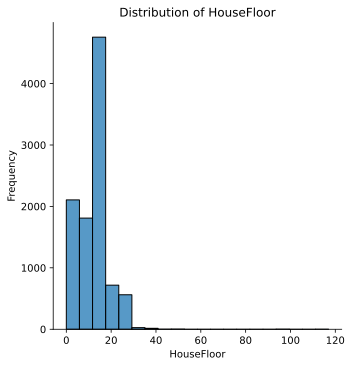

In [18]:
plt.figure(figsize=(14, 3))

sns.displot(df['HouseFloor'], bins=20)

plt.title(f'Distribution of HouseFloor')
plt.xlabel('HouseFloor')
plt.ylabel('Frequency')
plt.show()

In [19]:
df['HouseFloor'][df['HouseFloor'] > 40].value_counts()

99.0     2
48.0     2
117.0    1
44.0     1
47.0     1
45.0     1
Name: HouseFloor, dtype: int64

Судя по всему, значения более 40 являются ошибочными, приведем их к значению 40 при корректировке. Нулевые значения заменим на медианные.

In [20]:
(df['Floor'] > df['HouseFloor']).sum()

1825

In [21]:
df[df['Floor'] > df['HouseFloor']].sample(8)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,PricePerMeter,SquarePerRoom
Id,,,,,,,,,,,,,,,,,,,,,
9517,46,1.0,37.899788,24.621780,6.0,10,9.0,1979,0.188784,B,...,31,6137,4,NaN,0,1,B,162840.312500,4296.602051,37.899788
16726,119,2.0,51.313702,32.964130,6.0,10,9.0,1973,0.333892,B,...,30,6564,1,NaN,0,0,B,169089.593750,3295.213379,25.656851
11335,62,2.0,86.929466,83.432251,1.0,10,8.0,2018,0.072158,B,...,2,629,1,NaN,0,0,A,175178.531250,2015.180054,43.464733
8582,29,3.0,80.838371,45.049297,8.0,26,25.0,2010,0.069660,B,...,31,6119,4,NaN,1,2,B,256658.671875,3174.960938,26.946123
7245,119,1.0,36.643291,23.902304,5.0,6,5.0,1965,0.000995,B,...,42,7651,1,NaN,1,5,B,151461.937500,4133.415039,36.643291
1792,27,1.0,44.279694,NaN,0.0,9,0.0,1977,0.072158,B,...,2,629,1,NaN,0,0,A,149413.203125,3374.305176,44.279694
8941,46,1.0,35.440815,19.319683,6.0,10,9.0,1970,0.000000,B,...,47,11319,0,1145.0,3,5,B,168032.890625,4741.225586,35.440815
3239,120,1.0,36.570980,22.051735,7.0,6,5.0,1935,0.341072,B,...,27,5664,48,2300.0,3,11,B,200940.828125,5494.542969,36.570980


Поменяем значения Floor и HouseFloor местами.

#### HouseYear
Для данного признака все выбросы заменим на текущий год.

#### Прочие признаки (Ecology_1, Ecology_2, Ecology_3, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1, Shops_2)
Исключим признак Healthcare_1 с большим числом пропусков, остальные не будем трогать.
Дополнительное введем новую фичу - социальный коэффициент, рассчитываемую через значения Ecology_1, Social_1, Social_2, Social_3, Helthcare_2, Shops_1.


### 3. Подготовка данных и генерация фич

In [22]:
class Data:
    
    def __init__(self):
        """Константы для обработки выбросов на основе анализа данных"""
        self.current_year = datetime.datetime.now().year
        # медианы признаков для расчета новых фич
        self.medians = None
        # минимальная и максимальная площадь для доппроверки
        self.condition_min_square = 15
        self.condition_max_square = 150
        # минимальная жилая площадь
        self.condition_min_life_square = 10
        # максимальный коэффициент жилой площади к общей
        self.condition_min_coef_life_square = 0.9
        # минимальная площадь кухни
        self.condition_min_kitchen_square = 5       
        # максимальный коэффициент кухни к общей площади
        self.condition_min_coef_kitchen = 0.4
        # 0,1 % процентиль площади на комнату
        self.condition_low_square_per_room = None
        # 99,9 % процентиль площади на комнату
        self.condition_high_square_per_meter = None
        # 0,1 % процентиль стоимости метра
        self.condition_low_price_per_meter = None
        # 99,9 % процентиль стоимости метра
        self.condition_high_price_per_meter = None  
        # коэффициент отношения площади кухни к общей площади
        self.coef_kitchen_to_square = None
        # коэффициент отношения жилой площади к общей площади
        self.coef_life_to_square = None
        # коэффициент популярности района для расчета новой фичи
        self.DistrictId_value_counts = None
        # медианная цена за метр в районе для расчета новой фичи
        self.PricePerMeterByDistrict = None
        # медианная цена квартиры в районе для расчета новой фичи
        self.MedPriceByDistrict = None
        # для приведения категориальных признаков к цифровым значениям
        self.binary_to_numbers = None
          
    def fit(self, X, y):
        
        df_temp = X.copy()
                
        df_temp['Price'] = y.values
        
        condition_incorrect_life_square = ((df_temp.LifeSquare > self.condition_min_coef_life_square * df_temp.Square) |
                                            (df_temp.LifeSquare < self.condition_min_life_square) |
                                            (df_temp.LifeSquare.isna()))
        
        condition_incorrect_kitchen = (df_temp.KitchenSquare > self.condition_min_coef_kitchen * df_temp.Square) | (df_temp.KitchenSquare < self.condition_min_kitchen_square)
        
        # бинарные значения
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # медианные значения
        self.medians = df_temp[['Square', 'KitchenSquare', 'LifeSquare', 'HouseFloor']].median()
        self.medians['Square'] = df_temp['Square'][~condition_incorrect_life_square & ~condition_incorrect_kitchen].median()
        self.medians['KitchenSquare'] = df_temp['KitchenSquare'][~condition_incorrect_kitchen].median()
        self.medians['LifeSquare'] = df_temp['LifeSquare'][~condition_incorrect_life_square].median()
        self.medians['HouseFloor'] = df_temp['HouseFloor'][df_temp['HouseFloor'] != 0].median()
        
        # цена за метр
        df_temp['PricePerMeter'] = df_temp['Price'] / df_temp['Square']
        # площадь на комнату
        df_temp['SquarePerRoom'] = df_temp['Square'] / df_temp['Rooms']
        df_temp.loc[df_temp['SquarePerRoom'] == np.inf, 'SquarePerRoom'] = df_temp['Square']
        
        # 0,1 % процентиль площади на комнату
        self.condition_low_square_per_room = df_temp.SquarePerRoom.quantile(q=0.001)
        # 99,9 % процентиль площади на комнату
        self.condition_high_square_per_meter = df_temp.SquarePerRoom.quantile(q=0.999)
        # 0,1 % процентиль стоимости метра
        self.condition_low_price_per_meter = df_temp.PricePerMeter.quantile(q=0.001)
        # 99,9 % процентиль стоимости метра
        self.condition_high_price_per_meter = df_temp.PricePerMeter.quantile(q=0.999)

        # подсчет популярных районов
        self.DistrictId_value_counts = dict(X['DistrictId'].value_counts())
        
        # подсчет средней цены за м2 по району
        self.PricePerMeterByDistrict = df_temp.groupby('DistrictId', as_index=False).agg({'PricePerMeter': 'median'}).\
                                            rename(columns={'PricePerMeter': 'AveragePricePerMeterByDistrict'})
        self.MedPriceByDistrict = df_temp.groupby('DistrictId', as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict'})
       
        del df_temp

    def transform(self, X, y=None):   
        
        df_temp = X.copy()

        if y is not None:
            df_temp['Price'] = y.values
        
        condition_incorrect_life_square = ((df_temp.LifeSquare > self.condition_min_coef_life_square * df_temp.Square) |
                                           (df_temp.LifeSquare < self.condition_min_life_square) |
                                           (df_temp.LifeSquare.isna()))
        
        condition_incorrect_kitchen = ((df_temp.KitchenSquare > self.condition_min_coef_kitchen * df_temp.Square) | 
                                       (df_temp.KitchenSquare < self.condition_min_kitchen_square))
        
        condition_incorrect_kitchen_and_life = df_temp.KitchenSquare + df_temp.LifeSquare > df_temp.Square

        # цена за метр
        if y is not None:
            df_temp['PricePerMeter'] = df_temp['Price'] / df_temp['Square']
        # площадь на комнату
        df_temp['SquarePerRoom'] = df_temp['Square'] / df_temp['Rooms']
        df_temp.loc[df_temp['SquarePerRoom'] == np.inf, 'SquarePerRoom'] = df_temp['Square']
        
        if y is not None:
            condition_small_square = ((df_temp.Square < self.condition_min_square) &
                                      ((df_temp.PricePerMeter > self.condition_high_price_per_meter) |
                                       (df_temp.SquarePerRoom < self.condition_low_square_per_room))) 
        else:
            condition_small_square = ((df_temp.Square < self.condition_min_square) &
                                      (df_temp.SquarePerRoom < self.condition_low_square_per_room))

        if y is not None:
            condition_large_square = ((df_temp.Square > self.condition_max_square) &
                                      ((df_temp.PricePerMeter < self.condition_low_price_per_meter) |
                                       (df_temp.SquarePerRoom > self.condition_high_square_per_meter))) 
        else: 
            condition_large_square = ((df_temp.Square > self.condition_max_square) &
                                      (df_temp.SquarePerRoom > self.condition_high_square_per_meter))
        
        # корректировки данных
        # корректировка комнат
        X.loc[(X['Rooms'] == 0), 'Rooms'] = 1
        X.loc[(X['Rooms'] > 5), 'Rooms'] = 5
        
        # корректировка жилой площади
        X.loc[condition_incorrect_life_square, ['LifeSquare']] = X['Square'] * (self.medians['LifeSquare'] / self.medians['Square'])
        
        # корректировка площади кухни
        X.loc[condition_incorrect_kitchen, ['KitchenSquare']] = X['Square'] * self.medians['KitchenSquare'] / self.medians['Square']
        
        # корректировка жилой площади и кухни
        X.loc[condition_incorrect_kitchen_and_life, ['LifeSquare']] = X['Square'] * self.medians['LifeSquare'] / self.medians['Square']
        X.loc[condition_incorrect_kitchen_and_life, ['KitchenSquare']] = X['Square'] * self.medians['KitchenSquare'] / self.medians['Square']
        
        # корректировка этажа квартиры и этажности дома
        X.loc[X['Floor'] > X['HouseFloor'], ['Floor','HouseFloor']] = X.loc[X['Floor'] > X['HouseFloor'], ['HouseFloor','Floor']].values
        X.loc[(X['HouseFloor'] > 40), 'HouseFloor'] = 40
        X.loc[(X['HouseFloor'] == 0), 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor'].apply(lambda x: 1 if (x == 1) else np.random.randint(0, x) + 1)
        
        # корректировка года постройки дома
        X.loc[(X['HouseYear'] > self.current_year), 'HouseYear'] = self.current_year
        
        # обработка категорий
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X.drop('Healthcare_1', axis=1, inplace=True)
       
        # корректировка малых площадей
        X.loc[condition_small_square,['LifeSquare']] = X['Square'] * 10 * self.medians['LifeSquare'] / self.medians['Square']
        X.loc[condition_small_square,['KitchenSquare']] = X['Square'] * 10 * self.medians['KitchenSquare'] / self.medians['Square']                                                                                         
        X.loc[condition_small_square,['Square']] = X['Square'] * 10
        
        # корректировка больших площадей
        X.loc[condition_large_square,['LifeSquare']] = X['Square'] / 10 * self.medians['LifeSquare'] / self.medians['Square']
        X.loc[condition_large_square,['KitchenSquare']] = X['Square'] / 10 * self.medians['KitchenSquare'] / self.medians['Square']                                                                                         
        X.loc[condition_large_square,['Square']] = X['Square'] / 10
        
        del df_temp
        
        return X
               
    def features(self, X):
        # добавление признака популярности района
        X['DistrictId_counts'] = X['DistrictId'].map(self.DistrictId_value_counts)
        X['DistrictId_counts'].fillna(X['DistrictId_counts'].median(), inplace=True)
        # добавление признака средней стоимости м2 по району
        X = X.merge(self.PricePerMeterByDistrict, on=["DistrictId"], how='left')
        X['AveragePricePerMeterByDistrict'].fillna(X['AveragePricePerMeterByDistrict'].median(), inplace=True)
        X = X.merge(self.MedPriceByDistrict, on=['DistrictId'], how='left')
        X['MedPriceByDistrict'].fillna(X['MedPriceByDistrict'].median(), inplace=True)
        # новые категориальные признаки
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        # добавление признака с социальным коэффициентом
        X = self.social_coef(X)
        
        return X

    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[(X['Floor'] < 3) | (X['Floor'] == X['HouseFloor']), 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5) & (X['Floor'] != X['HouseFloor']), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 39) & (X['Floor'] != X['HouseFloor']), 'floor_cat'] = 3
          
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan

        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
    
    @staticmethod
    def social_coef(X):
        
        X['social_coef'] = np.nan
        feature_names_for_scaling = ['Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1']
        scaler = StandardScaler()
        stand_features = scaler.fit_transform(X[feature_names_for_scaling])
        X['social_coef'] = np.prod(stand_features, axis = 1)
        
        return X

In [23]:
data_inst = Data()

# тренировочные данные
data_inst.fit(X, y)
X = data_inst.transform(X, y)
X = data_inst.features(X)

# валидационные данные
X_final = data_inst.transform(X_final)
X_final = data_inst.features(X_final)

In [24]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                   'Ecology_1', 'Ecology_2', 'Ecology_3', 'Shops_2', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2',
                   'DistrictId_counts', 'AveragePricePerMeterByDistrict', 'MedPriceByDistrict', 'year_cat', 'floor_cat',
                   'social_coef']
X = X[remain_features]
X_final = X_final[remain_features]

#### В качестве модели выбран CatBoostRegressor, как наиболее быстрый для подбора гиперпараметров. 
Подбор гиперпараметров модели проводился через randomized_search.

In [25]:
%%time
final_model = CatBoostRegressor(
    silent=True,
    learning_rate=0.05,
    iterations=1150,
    eval_metric='R2',
    depth=7
)

final_model.fit(X, y)

cv_score = cross_val_score(
    final_model,
    X,
    y,
    scoring='r2',
    cv=KFold(
            n_splits=5,
            shuffle=True,
            random_state=42
    )
)

print(f'R2: {round(cv_score.mean(), 4)} +- {round(cv_score.std(), 4)}')

R2: 0.7663 +- 0.0162
Wall time: 24.5 s


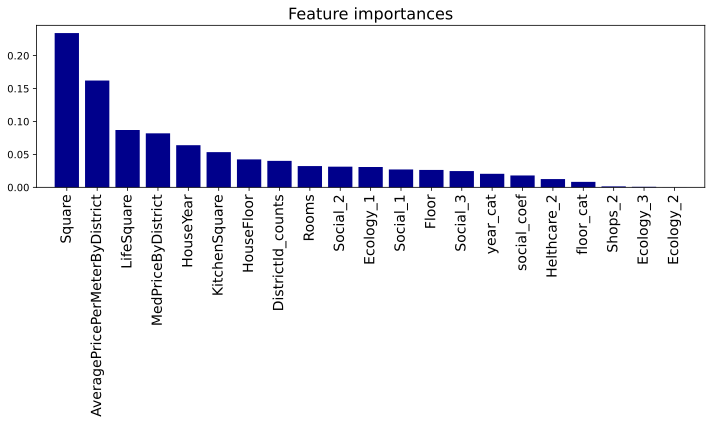

In [26]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (10, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = final_model.feature_importances_, X=X)

In [27]:
y_pred_final = final_model.predict(X_final)
print(X_final.shape)
print(y_pred_final.shape)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

(5000, 21)
(5000,)


,Id,Price
0,725,154712.068074
1,15856,227402.808425
2,5480,292269.260507
3,15664,321274.500856
4,14275,143313.024613


In [28]:
preds_final.shape

(5000, 2)